In [16]:
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
sys.path.insert(0, "/home/sujatha/Dropbox/Aseem")

In [17]:
import CosmologyLibraryM as cslb
import cosmolopy.perturbation as cseu
import cosmolopy as csp
import matplotlib.gridspec as gridspec
import camb

In [18]:
from camb import model, initialpower

## Initialising Cosmological Parameters

In [19]:
h = 0.7
omega_matter = 0.25
omega_baryon = 0.045
omega_cdm = omega_matter-omega_baryon
omega_lambda = 0.75
ns = 0.96
sigma_8 = 0.8
redshift = 100.

### For bbks and ehu

In [20]:
#cosmology = csp.parameters.WMAP7_BAO_H0_mean(flat=False, extras=True)
cosmology = {'tau': 0.087, 'omega_n_0': 0.0, 'sigma_8': sigma_8, 'h': h, 'N_nu': 0, 'omega_lambda_0': omega_lambda, 'n': 0.963, 'Y_He': 0.24, 'z_reion': 10.4, 'omega_b_0': omega_baryon, 't_0': 13.75, 'omega_M_0': omega_matter}
c = cslb.cosmology(Omega_matter = omega_matter,Omega_lambda = omega_lambda,H_0=100.*h,ns=ns,sigma_8 = sigma_8,Omega_baryon = omega_baryon)

### Cosmological parameters in pycamb

In [21]:
pars = camb.CAMBparams() #Object storing the parameters for a CAMB calculation, 
#including cosmological parameters and settings for what to calculate. 
#When a new object is instantiated, default parameters are set

In [22]:
pars.set_cosmology(H0=100*h,ombh2=omega_baryon*h**2, omch2=omega_cdm*h**2) #Sets cosmological parameters in terms of physical densities and parameters used in Planck 2015 analysis.
pars.set_dark_energy() #re-set defaults
###The code below prints some of the default cosmological parameters
print pars.H0  # :param H0: Hubble parameter (in km/s/Mpc)
print pars.omegab  #Omega baryon
print pars.omegac  #Omega cold dark matter

70.0
0.045
0.205


In [23]:
pars.InitPower.set_params(ns=ns)
pars.set_matter_power(redshifts=[0.], kmax=100.0)

## Transfer Function
### PyCAMB Transfer Function 

In [24]:
tran = camb.get_transfer_functions(pars)
s=tran.get_matter_transfer_data()

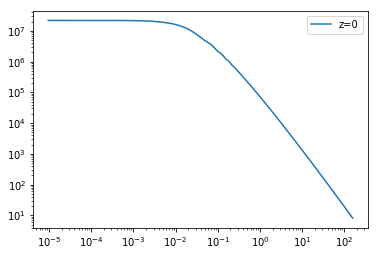

In [25]:
kh_pycamb= s.transfer_z( "k/h", z_index=0)
T_pycamb= s.transfer_z( 'delta_cdm', z_index=0)
plt.loglog(kh_pycamb,T_pycamb,label='z=0')
plt.xscale('log')
plt.legend()
plt.show()

### BBKS and EHu Transfer Function

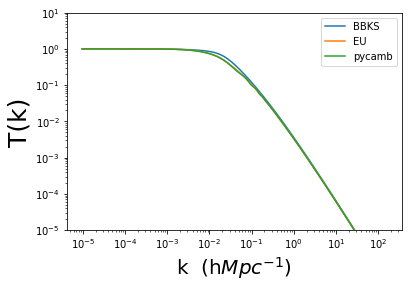

In [26]:
kh = kh_pycamb  ## is float32
k=kh.astype(float) * h ## converts to float64 which seems necessary for EHu tranfer function
T_bbks = c.BBKS_tf(kh)
T_eu = cseu.transfer_function_EH(k, **cosmology)
plt.loglog(kh,T_bbks,label='BBKS')
plt.loglog(kh,T_eu[0],label='EU')
plt.loglog(kh_pycamb,T_pycamb/np.amax(T_pycamb),label='pycamb')
plt.xlabel('k  (h$Mpc^{-1}$)',fontsize=20)
plt.ylabel('T(k)',fontsize=25)
plt.ylim([1e-5,10])
plt.legend()
plt.show()
plt.clf()

## Power Spectrum

0.00011266 0.000176031856787 0.000176031869614


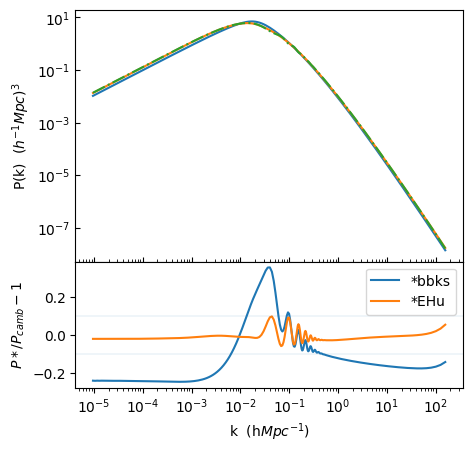

24.4971 -35.4717
5.7839409933 -9.77882559606


In [27]:
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[:-1,:])
PS_bbks = c.PS(kh,redshift,T_bbks)
PS_eu = c.PS(kh,redshift,T_eu[0])
PS_pycamb = c.PS(kh_pycamb,redshift,T_pycamb)

## Sanity Check - int P(k)/(2 pi)^3 wR(k)^2 4 pi k^2 dk = sigma^2(R) = 0.8^2
w8 = c.Wk(kh,R=8)
integrand_bbks = PS_bbks/(2* np.pi)**3 * w8**2 * 4* np.pi * kh**2 
integrand_ehu = PS_eu /(2* np.pi)**3 * w8**2 * 4* np.pi * kh**2 
integrand_pycamb = PS_pycamb /(2* np.pi)**3 * w8**2 * 4* np.pi * kh**2
ax2 = plt.subplot(gs[2, :])
print np.trapz(integrand_bbks,kh),np.trapz(integrand_ehu,kh)/(0.8)**2,np.trapz(integrand_pycamb,kh)/(0.8)**2

ax1.loglog(kh,PS_bbks,label='BBKS')
ax1.loglog(kh,PS_eu,label='EHu')
ax1.loglog(kh_pycamb,PS_pycamb,label='pycamb',linestyle='-.')
plt.setp(ax1.get_xticklabels(), visible=True)
ax1.set_ylabel('P(k)  ($h^{-1}Mpc)^3$')
plt.legend(loc='lower left')

ax2.semilogx(kh,PS_bbks/PS_pycamb-1,label='*bbks')
ax2.semilogx(kh,PS_eu/PS_pycamb-1,label='*EHu')
plt.axhline(y=0.1,linewidth=0.1)
plt.axhline(y=-0.1,linewidth=0.1)
gs.update(hspace=0, wspace=0)
ax2.set_xlabel('k  (h$Mpc^{-1}$)')
ax2.set_ylabel('$P*/P_{camb}-1$')
ax2.legend()
#ax1.xaxis.set_tick_params(size=10)
#ax1.patch.set_facecolor('None')
#ax2.patch.set_facecolor('None')
ax1.tick_params(direction='in',which='both')
plt.show()
print np.amax((PS_pycamb-PS_bbks)/PS_pycamb*100),np.amin((PS_pycamb-PS_bbks)/PS_pycamb*100)
print np.amax((PS_pycamb-PS_eu)/PS_pycamb*100),np.amin((PS_pycamb-PS_eu)/PS_pycamb*100)

## Dimensionless Power Spectrum

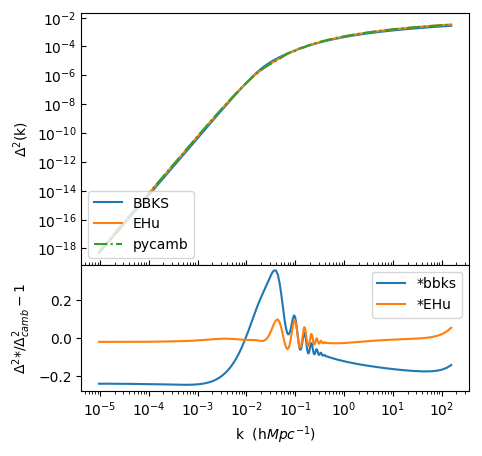

24.4971 -35.4717


In [28]:
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[:-1,:])
PS_bbks = c.PS(kh,redshift,T_bbks)*kh_pycamb**3/(2*np.pi**2)
PS_eu = c.PS(kh,redshift,T_eu[0])*kh_pycamb**3/(2*np.pi**2)
PS_pycamb = c.PS(kh_pycamb,redshift,T_pycamb)*kh_pycamb**3/(2*np.pi**2)
ax1.loglog(kh,PS_bbks,label='BBKS')
ax1.loglog(kh,PS_eu,label='EHu')
ax1.loglog(kh_pycamb,PS_pycamb,label='pycamb',linestyle='-.')
plt.setp(ax1.get_xticklabels(), visible=True)
ax1.set_ylabel('$\Delta^2$(k)')
plt.legend(loc='lower left')
ax2 = plt.subplot(gs[2, :])
ax2.semilogx(kh,PS_bbks/PS_pycamb-1,label='*bbks')
ax2.semilogx(kh,PS_eu/PS_pycamb-1,label='*EHu')
gs.update(hspace=0, wspace=0)
ax2.set_xlabel('k  (h$Mpc^{-1}$)')
ax2.set_ylabel('$\Delta^2$*/$\Delta^2_{camb}-1$')
ax2.legend()
#ax1.xaxis.set_tick_params(size=10)
#ax1.patch.set_facecolor('None')
#ax2.patch.set_facecolor('None')
ax1.tick_params(direction='in',which='both')
plt.show()
print np.amax((PS_pycamb-PS_bbks)/PS_pycamb*100),np.amin((PS_pycamb-PS_bbks)/PS_pycamb*100)